## Data Exploration

In [81]:

s3_bucket_path="s3://aegovan-data/human_output/human_keyinteractions.json"


In [82]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [83]:
data_file="input_data.json"
download_single_file(s3_bucket_path, data_file)

In [92]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records 3381


Sneak preview of the data

In [93]:
data.head(n=10)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
1,2503513,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
10,1796163,phosphorylation,false,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_hum...",25500533,None,"LRRK2, a gene relevant to Parkinson's disease,..."
100,2392979,phosphorylation,false,"[{'uniprotid': 'A4D2Q5', 'alias': [['fa20c_hum...",22582013,None,Protein phosphorylation is a fundamental mecha...
1000,1160297,phosphorylation,false,"[{'uniprotid': None, 'alias': None}, {'uniprot...",20856200,None,The PI3K/AKT signaling pathway is aberrant in ...
1001,1160335,phosphorylation,false,"[{'uniprotid': 'B7Z5R1', 'alias': [['akt1_huma...",20856200,None,The PI3K/AKT signaling pathway is aberrant in ...
1002,1160459,phosphorylation,false,"[{'uniprotid': 'Q15153', 'alias': [['plk1_huma...",20890306,None,Phosphorylation of the Fas-associated death do...
1003,1160465,phosphorylation,false,"[{'uniprotid': 'Q15153', 'alias': [['plk1_huma...",20890306,None,Phosphorylation of the Fas-associated death do...
1004,1160473,phosphorylation,false,"[{'uniprotid': 'Q15153', 'alias': [['plk1_huma...",20890306,None,Phosphorylation of the Fas-associated death do...
1005,2665902,dephosphorylation,false,"[{'uniprotid': 'Q5F298', 'alias': [['rpb1_mous...",20861839,Crystal structure of the human symplekin-Ssu72...,Symplekin (Pta1 in yeast) is a scaffold in the...


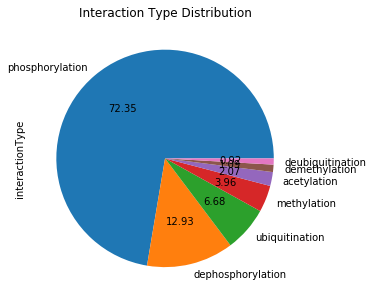

In [86]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Interaction Type Distribution')
plt.show()

In [95]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


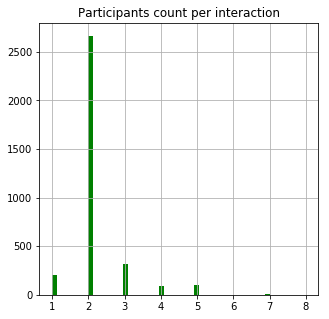

In [87]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

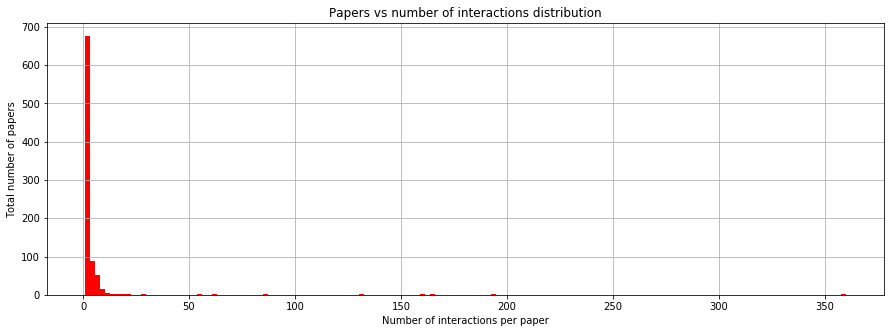

In [88]:
data.pubmedId.value_counts().hist (bins=150, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

Explore if the abstract contains the trigger word

In [109]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"] in r["pubmedabstract"] , 1)

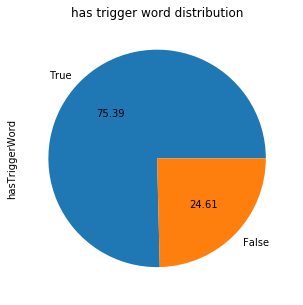

In [110]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

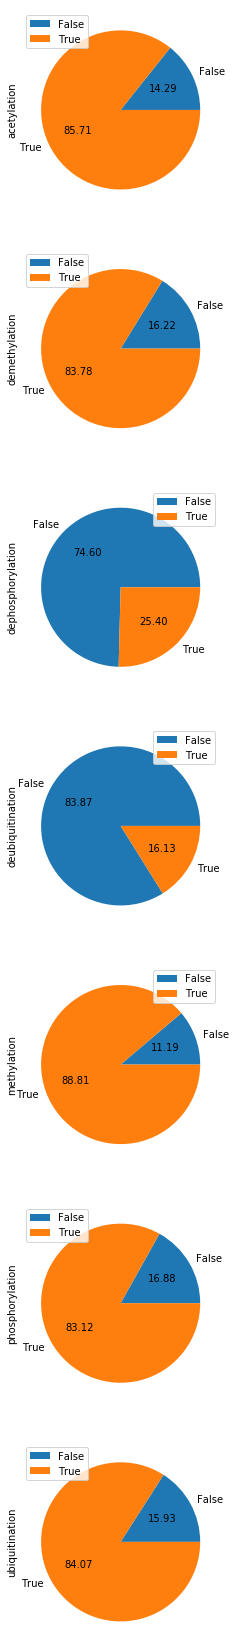

In [155]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()